In [53]:
from amplpy import AMPL, modules
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [54]:
from scipy.optimize import linprog
import numpy as np
import pandas as pd
import plotly.express as px
import datetime


import plotly.graph_objects as go
from plotly.subplots import make_subplots

from battery_simulator.battery import Battery, get_SOC_DT_functions, get_SOC_CT_functions
from datetime import timedelta
import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Battery specs :



- SOC: state of charge in [0,1]
- NEC: nominal energy capacity (Wh)
- EC: energy capacity (Wh)




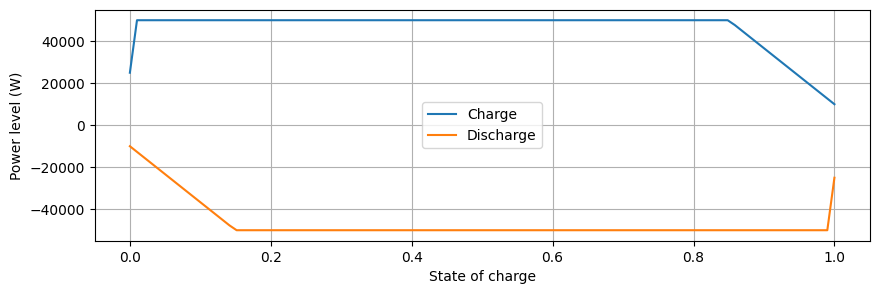

In [68]:
NEC = 100000
SOC = np.array([0,0.01, 0.85, 1.])

# Charging curve 
CPL = np.array([0.25, 0.5, 0.5, 0.1]) * NEC
SOC_to_CPL_function = interp1d(SOC, CPL)

# Discharging curve 
SOC = np.array([0.  , 0.15, 0.99, 1.  ])
DPL = np.array([0.1, 0.5, 0.5, 0.25]) * NEC
SOC_to_DPL_function = interp1d(SOC, DPL)


plt.figure(figsize=(10,3))
plt.plot(np.linspace(0,1,100), SOC_to_CPL_function(np.linspace(0,1,100)), label = "Charge")
plt.plot(np.linspace(0,1,100), -SOC_to_DPL_function(np.linspace(0,1,100)), label = "Discharge")
plt.grid(True)
plt.xlabel("State of charge")
plt.ylabel("Power level (W)")
plt.legend()

bat = Battery(SOC_to_CPL_function, SOC_to_DPL_function, NEC = NEC)





# get max capacity change in one hour of charge/ discharge

In [72]:
def get_max_energy_change(bat,S,) :
    NEC = bat.NEC
    capacity_change_charge = []
    capacity_change_discharge = []

    for SOC_init in S :
        EC_init = SOC_init * NEC
        EC = EC_init
        for t in range(3600) :
            EC = min(NEC,EC + 1/3600 * bat.SOC_to_CPL_function(EC/NEC))
        capacity_change_charge.append(EC-EC_init)

        
    for SOC_init in S :
        EC_init = SOC_init * NEC
        EC = EC_init
        for t in range(3600) :
            EC = max(0,EC- 1/3600 * bat.SOC_to_DPL_function(EC/NEC))
        capacity_change_discharge.append( (EC-EC_init) )

        
    return capacity_change_charge, capacity_change_discharge

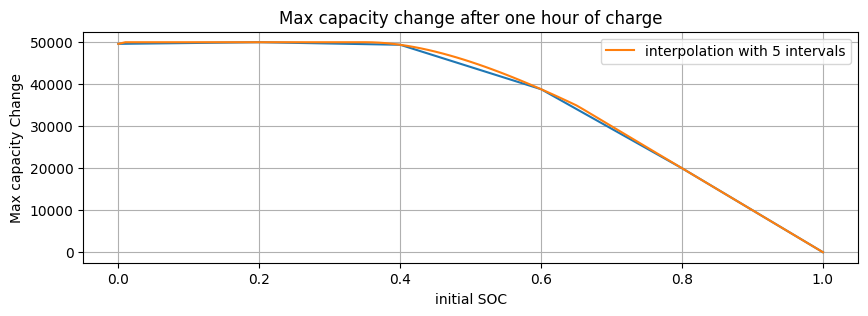

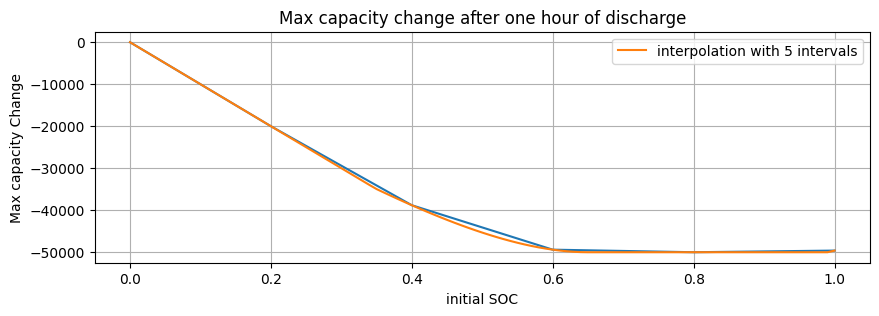

In [73]:
Nint = 5
S = np.linspace(0,1,Nint+1)
G_c, G_d = get_max_energy_change(bat,S)


Nint2 = 100
S2 = np.linspace(0,1,Nint2+1)
G_c2, G_d2 = get_max_energy_change(bat,S2)

plt.figure(figsize=(10,3))
plt.grid(True)
plt.plot(S,G_c)
plt.plot(S2,G_c2,label="interpolation with {} intervals".format(Nint))
plt.ylabel("Max capacity Change")
plt.xlabel("initial SOC")
plt.title("Max capacity change after one hour of charge")
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.grid(True)
plt.plot(S,G_d)
plt.plot(S2,G_d2,label="interpolation with {} intervals".format(Nint))
plt.ylabel("Max capacity Change")
plt.xlabel("initial SOC")
plt.title("Max capacity change after one hour of discharge")
plt.legend()
plt.show()




# Schedule optimization functions :

In [6]:
def optimize_day_by_day_forecasted_prices(bat,df,frame_size=14) :
    """
    Returns a copy of the initial price data frame, with three additional columns :
    - schedule: Change in EC during the hour
    - capacity: Capacity at the end of the hour
    - SOC: SOC at the end of the hour 

    The schedule is optimized **for each day of the dataframe, considered separately.** 
    """


    n_cycles = 0
    init_eff = 0.99
    max_cycles = 4000
    min_eff = init_eff * 0.8
    eff = init_eff
    eff_decrease_rate = (init_eff - min_eff)/max_cycles
    
    modules.load() # load all AMPL modules
    ampl = AMPL() # instantiate AMPL object
    ampl.read("ampl.mod")


    Nint = 5
    

    S = np.linspace(0,1,Nint+1)

    G_c, G_d = get_max_capacity_change(bat,S)




    
    n_hours = len(df)
    if  n_hours % 24 != 0 :
        raise Exception("The dataframe should contain only full days (24 hours)")
    
    schedule = np.zeros(n_hours)
    n_cycles_list = np.zeros(n_hours)
    eff_list = np.zeros(n_hours)

    
    ## first day starts with empty battery :
    # initial_capacity = 0
    
    ## optimization done for each day :
    for day in range(frame_size,n_hours//24) :


        if day % frame_size == 0 :
            price = df.iloc[(day-frame_size)*24:day*24,:].groupby(df.timestamp.dt.hour).price_euros_wh.mean().to_numpy()

        ampl = AMPL() # instantiate AMPL object
        ampl.read("ampl.mod")
        vgc = df.vgc.iloc[day*24:(day+1)*24].to_numpy()
        ampl.get_parameter("p").set_values(price)
        ampl.get_parameter("vgc").set_values(vgc)
        ampl.get_parameter("eff").set_values([eff])
        ampl.get_parameter("Nint").set_values([Nint])
        # ampl.get_parameter("EC_init").set_values([initial_capacity])
        ampl.get_parameter("max_SOC").set_values([1]*23 + [0])
        ampl.get_parameter("G_c").set_values(np.array(G_c))
        ampl.get_parameter("G_d").set_values(np.array(G_d))
        ampl.get_parameter("NEC").set_values([bat.NEC])

        # Specify the solver to use (e.g., HiGHS)
        ampl.option["solver"] = "gurobi"
        # Solve
        ampl.solve()
        daily_schedule = ampl.get_variable('x').get_values().to_pandas()["x.val"]
        n_cycles += abs(daily_schedule).sum()/(2*bat.NEC)
        eff = max(min_eff, init_eff - n_cycles * eff_decrease_rate)
        eff_list[day*24:(day+1)*24] = eff
        n_cycles_list[day*24:(day+1)*24] = n_cycles
        ampl.reset()
        schedule[day*24:(day+1)*24]  = daily_schedule
        
    
    df_optim = df.copy()
    df_optim['eff']=eff_list
    df_optim["n_cycles"] = n_cycles_list
    df_optim["schedule"] = schedule
    df_optim["capacity"] = np.hstack((np.array([0]),np.cumsum(schedule)[:-1]))
    df_optim["SOC"] = 100*df_optim["capacity"]/NEC

    df_optim["charge_energy"] = df_optim.schedule.mask(df_optim.schedule < 0, 0)
    df_optim["discharge_energy"] = - df_optim.schedule.mask(df_optim.schedule > 0, 0) * df_optim.eff
    df_optim["electricity_revenue"] = df_optim.price_euros_wh * (df_optim.discharge_energy - df_optim.charge_energy)
    df_optim["grid_cost"] = df_optim.vgc * (df_optim.discharge_energy - df_optim.charge_energy)
    df_optim["hourly_profit"] = df_optim["electricity_revenue"]-df_optim["grid_cost"]
    return df_optim.iloc[frame_size*24:]

        
        


In [12]:
def optimize_day_by_day(bat,df) :
    """
    Returns a copy of the initial price data frame, with three additional columns :
    - schedule: Change in EC during the hour
    - capacity: Capacity at the end of the hour
    - SOC: SOC at the end of the hour 

    The schedule is optimized **for each day of the dataframe, considered separately.** 
    """
   
    n_cycles = 0
    init_eff = 0.99
    max_cycles = 4000
    min_eff = init_eff * 0.8
    eff = init_eff
    eff_decrease_rate = (init_eff - min_eff)/max_cycles

    modules.load() # load all AMPL modules
    ampl = AMPL() # instantiate AMPL object
    ampl.read("ampl.mod")


    Nint = 5
    

    S = np.linspace(0,1,Nint+1)

    G_c, G_d = get_max_capacity_change(bat,S)




    
    n_hours = len(df)
    if  n_hours % 24 != 0 :
        raise Exception("The dataframe should contain only full days (24 hours)")
    
    schedule = np.zeros(n_hours)
    n_cycles_list = np.zeros(n_hours)
    eff_list = np.zeros(n_hours)
    
    ## first day starts with empty battery :
    initial_capacity = 0
    
    ## optimization done for each day :
    for day in range(0,n_hours//24) :



        price = df.price_euros_wh.iloc[day*24:(day+1)*24].to_numpy()

        ampl = AMPL() # instantiate AMPL object
        ampl.read("ampl.mod")
        vgc = df.vgc.iloc[day*24:(day+1)*24].to_numpy()
        ampl.get_parameter("p").set_values(price)
        ampl.get_parameter("vgc").set_values(vgc)
        ampl.get_parameter("eff").set_values([eff])
        ampl.get_parameter("Nint").set_values([Nint])
        ampl.get_parameter("EC_init").set_values([initial_capacity])
        ampl.get_parameter("max_SOC").set_values([1]*23 + [1])
        # ampl.get_parameter("G_c").set_values(np.array(G_c))
        ampl.get_parameter("G_d").set_values(np.array(G_d))
        ampl.get_parameter("NEC").set_values([bat.NEC])

        # Specify the solver to use (e.g., HiGHS)
        ampl.option["solver"] = "gurobi"
        # Solve
        ampl.solve()
        daily_schedule = ampl.get_variable('x').get_values().to_pandas()["x.val"]
        n_cycles += abs(daily_schedule).sum()/(2*bat.NEC)
        eff = max(min_eff, init_eff - n_cycles * eff_decrease_rate)
        eff_list[day*24:(day+1)*24] = eff
        n_cycles_list[day*24:(day+1)*24] = n_cycles
        ampl.reset()
        schedule[day*24:(day+1)*24]  = daily_schedule
        initial_capacity = round(initial_capacity + sum(schedule[day*24:(day+1)*24]))

        
    
    df_optim = df.copy()
    df_optim['eff']=eff_list
    df_optim["n_cycles"] = n_cycles_list
    df_optim["schedule"] = schedule
    df_optim["capacity"] = np.hstack((np.array([0]),np.cumsum(schedule)[:-1]))
    df_optim["SOC"] = 100*df_optim["capacity"]/NEC

    df_optim["charge_energy"] = df_optim.schedule.mask(df_optim.schedule < 0, 0)
    df_optim["discharge_energy"] = - df_optim.schedule.mask(df_optim.schedule > 0, 0) * df_optim.eff
    df_optim["electricity_revenue"] = df_optim.price_euros_wh * (df_optim.discharge_energy - df_optim.charge_energy)
    df_optim["grid_cost"] = df_optim.vgc * (df_optim.discharge_energy + df_optim.charge_energy)
    df_optim["hourly_profit"] = df_optim["electricity_revenue"]-df_optim["grid_cost"]
   
    return df_optim

        



# Plot functions :

In [13]:
def display_profit(df_optim) :
    """
    Displays daily profits 
    """

    days = pd.to_datetime(df_optim["timestamp"].apply(lambda x: datetime.datetime(x.year, x.month, x.day)),utc=True).unique()
    daily_profit = []


    for i in range(len(days)) :
        daily_profit.append(df_optim.hourly_profit.iloc[i*24:(i+1)*24].sum())

    fig = make_subplots(specs=[[{"secondary_y": True}]])


    fig.add_trace(go.Scatter(x=df_optim.timestamp, y=df_optim.price_euros_wh*10**6,name='Price (EUR/MWh)',line={"shape":"hv"},showlegend=True),
    secondary_y=False)

    fig.add_trace(go.Bar(x=days,y=daily_profit,name="Daily profit (EUR)",offset=2,showlegend=True,opacity=0.5),
    secondary_y=True)

    fig.update_layout(
    title_text="Daily profit<br>Total: {} EUR<br>Mean: {} EUR".format(int(sum(daily_profit)), int(np.mean(daily_profit)))
    )

    fig.update_xaxes(title_text="Hour")

    fig.update_yaxes(title_text="Price (EUR/MWh)", secondary_y=False)
    fig.update_yaxes(title_text="Daily profit (EUR)", secondary_y=True)

    fig.update_layout(bargap=0.)
    fig.write_html("out/profit.html")
    fig.show()
    


    
    



def display_schedule(df_optim,start,end) :
    """
    Displays charge schedule between start datetime and end datetime 
    """
		
    mask = (df_optim.timestamp<end) & (df_optim.timestamp>=start)
    df_to_show = df_optim[mask]


    fig = make_subplots(specs=[[{"secondary_y": True}]])


    fig.add_trace(go.Scatter(x=df_to_show.timestamp, y=df_to_show.price_euros_wh*10**6,name='Price (EUR/MWh)',line={"shape":"hv"},showlegend=True),
        secondary_y=False)

    fig.add_trace(
        go.Scatter(x=df_to_show.timestamp,y=df_to_show.SOC,name="SOC (%)",showlegend=True),secondary_y=True)



    color = None 
    count = 0

    shapes = []


    for h in df_to_show.index[np.sign(df_to_show.schedule).diff() != 0] : 
        
       
        if (df_to_show.schedule[h] == 0 and not color) or (df_to_show.schedule[h] > 0  and color == "green") or (df_to_show.schedule[h] < 0  and color == "red") :
            continue

        elif df_to_show.schedule[h] == 0 and color :
            shapes.append(dict(type="rect",x0=df_to_show.timestamp[start], y0=1, x1=df_to_show.timestamp[h], y1=100,  yref="y2",fillcolor=color, opacity=0.25, line_width=0))
            color = None

        elif df_to_show.schedule[h] > 0 and color == "red" : 
            shapes.append(dict(type="rect",x0=df_to_show.timestamp[start], y0=1, x1=df_to_show.timestamp[h], y1=100, yref="y2",fillcolor=color, opacity=0.25, line_width=0))
            start = h 
            color = "green"

        elif df_to_show.schedule[h] > 0 and not color :
            start = h
            color = "green"
            
        elif df_to_show.schedule[h] < 0 and color == "green" : 
            shapes.append(dict(type="rect",x0=df_to_show.timestamp[start], y0=1, x1=df_to_show.timestamp[h], y1=100, yref="y2", fillcolor=color, opacity=0.25, line_width=0))
            start = h 
            color = "red"
            
        elif df_to_show.schedule[h] < 0 and not color :
            start = h
            color = "red"






    # Add range slider
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(step="all"),
                    dict(count=1,
                        label="1m",
                        step="month",
                        stepmode="backward"),
                    dict(count=2*7,
                        label="2w",
                        step="day",
                        stepmode="backward"),
                    dict(count=1*7,
                        label="1w",
                        step="day",
                        stepmode="backward"),
                    dict(count=2,
                        label="2d",
                        step="day",
                        stepmode="backward"),
                    dict(count=1,
                        label="1d",
                        step="day",
                        stepmode="backward"),
                    
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig.update_layout(
        shapes=shapes)


    fig.update_layout(
    title_text="Charge schedule.    Please use the buttons below to set the data range.<br>"
    )

    fig.update_xaxes(title_text="Date")

    fig.update_yaxes(title_text="Price (EUR/MWh)", secondary_y=False)
    fig.update_yaxes(title_text="SOC (%)", secondary_y=True)
        
    fig.show()  
    fig.write_html("out/schedule.html")





    

# Price dataset :

In [14]:
df = pd.read_csv("data/european_wholesale_electricity_price_data_hourly.csv")
df.rename(columns={"Datetime (UTC)":"timestamp","Price (EUR/MWhe)":"price_euros_wh"},inplace=True, errors='raise')
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%dT%H:%M:%S.%f%Z")

df.price_euros_wh /= 10 ** 6

start = "2022-01-01 00:00:00"
end = "2023-01-01 00:00:00"
country = "Germany"

df = df[df["Country"] == country]
mask = (df.timestamp<end) & (df.timestamp>=start)
df = df[mask]
df["vgc"] = 5 / 10 ** 6 # vgc of 5 EUR/ MWh
# df["vgc"] = 10 / 10 ** 6 # vgc of 10 EUR/ MWh



# Optimize and show schedule :

In [15]:
df_optim = optimize_day_by_day(bat,df[:24*30])

0.0
initial DT 8292.911967667922
-2.231243993946356e-07
20000.0
initial DT 5760.178833019302
-2.231243993946356e-07
40000.0
initial DT 4320.178833004634
0.011924219327109412
60000.00000000001
initial DT 2880.1788329899655
0.10611142160945836
80000.0
initial DT 1440.1788329891176
0.3000000000031736
100000.0
initial DT 0.0
0.5000248379162914
[-0.022312439939463562, -20000.02231243994, -38807.57806728906, -49388.85783905417, -49999.999999682645, -49997.516208370864]
[0.  0.2 0.4 0.6 0.8 1. ]
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 11.08800975
967 simplex iterations
1 branching nodes
absmipgap=5.55467e-12, relmipgap=0
[-0.022312439939463562, -20000.02231243994, -38807.57806728906, -49388.85783905417, -49999.999999682645, -49997.516208370864]
[0.  0.2 0.4 0.6 0.8 1. ]
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 6.594679278
763 simplex iterations
1 branching nodes
absmipgap=5.85754e-12, relmipgap=0
[-0.022312439939463562, -20000.02231243994, -38807.57806728906, 

# Show profits :

In [16]:
start_show = start
end_show = end
display_schedule(df_optim,start_show,end_show)

In [51]:
display_profit(df_optim)